In [2]:
import numpy as np
import pandas as pd
import strategy_testing as st
import misc
import matplotlib.pyplot as plt


In [3]:

spy_df = pd.read_csv('stock_price_data/SPY.csv')
spy_df = misc.clean_df(spy_df)
spy_df

,date,open,high,low,close,adjclose,volume,ticker
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.218227,1003200,SPY
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397591,480500,SPY
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451382,201300,SPY
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720436,529400,SPY
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828062,531500,SPY
...,...,...,...,...,...,...,...,...
7577,2023-03-03,399.709991,404.450012,399.029999,404.190002,404.190002,90038300,SPY
7578,2023-03-06,405.049988,407.450012,404.010010,404.470001,404.470001,72795900,SPY
7579,2023-03-07,404.420013,404.670013,397.630005,398.269989,398.269989,108310600,SPY
7580,2023-03-08,398.390015,399.709991,396.589996,398.920013,398.920013,74746600,SPY


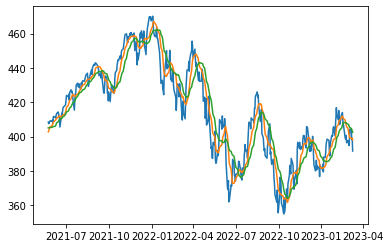

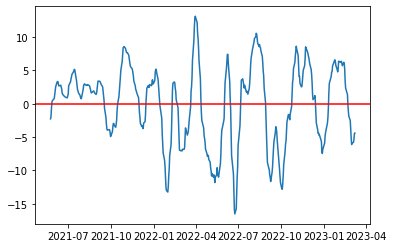

In [12]:


trade_list = []
df = spy_df.copy()
df = df.iloc[-471:]
df['ma1'] = df['adjclose'].rolling(10).mean()
df['ma2'] = df['adjclose'].rolling(20).mean()
df = df.dropna()
df['signal'] = df['ma1'] - df['ma2']


plt.plot(df['date'], df['adjclose'])
plt.plot(df['date'], df['ma1'])
plt.plot(df['date'], df['ma2'])
plt.show()

plt.plot(df['date'], df['signal'])
plt.axhline(0, color='red')
plt.show()



# for i in range(2, len(df)):

#     if df.iloc[i - 2]['signal'] < 0 and df.iloc[i - 1]['signal'] > 0:
        



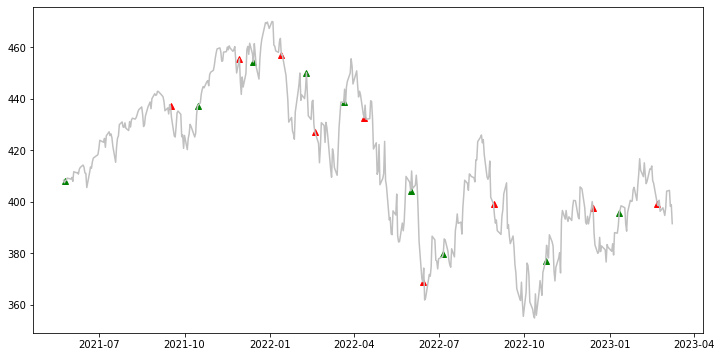

In [35]:
trade = df[['date', 'adjclose', 'signal']].copy()
trade['signal-1'] = trade['signal'].shift(-1)
trade['buy'] = None
trade['sell'] = None

trade['position'] = None
trade['position_value'] = None
trade['cash'] = None


position = 0


trade.loc[(trade['signal-1'] > 0) & (trade['signal'] < 0), 'buy'] = trade['adjclose']
trade.loc[(trade['signal-1'] < 0) & (trade['signal'] > 0), 'sell'] = trade['adjclose']


plt.figure(figsize=(12,6))
plt.plot(trade['date'], trade['buy'], marker='^', color='green', linestyle='None')
plt.plot(trade['date'], trade['sell'], marker='^', color='red', linestyle='None')
plt.plot(trade['date'], trade['adjclose'], color='silver')

plt.show()

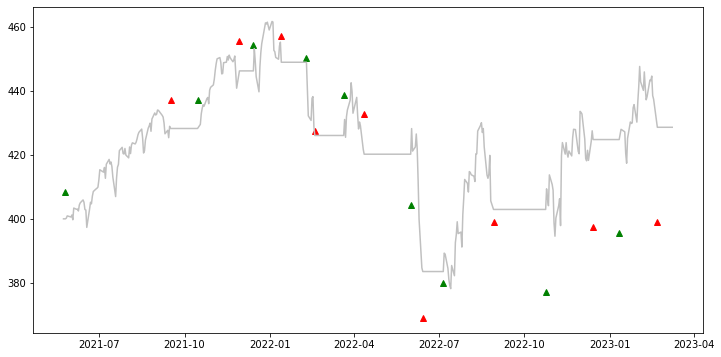

In [48]:
initial_capital = 1e6
cash = initial_capital
position = 0
position_value = 0



for i in range(len(trade)):

    if trade.loc[trade.index[i], 'buy'] is not None:
        quantity = cash // trade.loc[trade.index[i],'adjclose']
        position = quantity
        cash -= quantity * trade.loc[trade.index[i],'adjclose']
    
    if trade.loc[trade.index[i], 'sell'] is not None:
        quantity = position
        position = 0
        cash += quantity * trade.loc[trade.index[i],'adjclose']
    
    

    trade.loc[df.index[i], 'position'] = position
    trade.loc[df.index[i], 'cash'] = cash

trade['position_value'] = trade['adjclose'] * trade['position']
trade['portfolio_value'] = trade['cash'] + trade['position_value']

plt.figure(figsize=(12,6))
plt.plot(trade['date'], trade['buy'], marker='^', color='green', linestyle='None')
plt.plot(trade['date'], trade['sell'], marker='^', color='red', linestyle='None')
plt.plot(trade['date'], trade['portfolio_value']*400/1e6, color='silver')

plt.show()

In [7]:
def buy_hold_strategy(ohlcv, initial_capital, leverage=1):
    '''
    Takes a dataframe of OHLCV data and returns a list of trades to be performed.

    Trade list in the format:
    entry_date | entry_price | position | exit_date | exit_price | profit

    Portfolio tracker in the format:

    '''

    trade_list = [(ohlcv['date'][0], 
                   ohlcv['adjclose'][0], 
                   initial_capital * leverage // ohlcv['adjclose'][0],
                   ohlcv['date'].iat[-1],
                   ohlcv['adjclose'].iat[-1],
                   (ohlcv['adjclose'].iat[-1] - ohlcv['adjclose'][0]) * initial_capital * leverage // ohlcv['adjclose'][0])]
    
    df = ohlcv['date'].copy().to_frame()
    df['position value'] = 0
    df['cash'] = initial_capital
    df['margin'] = 0

    
    for trade in trade_list:
        df.loc[(df['date'] >= trade[0]) & (df['date'] < trade[3]), 'position value'] += trade[2] * ohlcv['adjclose']
        df.loc[(df['date'] >= trade[0]) & (df['date'] <= trade[3]), 'cash'] -= trade[2] * trade[1]
        df.loc[(df['date'] >= trade[3]), 'cash'] += trade[5]
    
    df['market value'] = df['position value'] + df['cash']

    return trade_list, df

trade_list, df = buy_hold_strategy(df, 1E6)
print(df)

KeyError: 0

In [ ]:
def portfolio_changes(ohlcv, trade_list, initial_capital):
    '''
    Tracks portfolio stats over the course of the times series

    Stats tracked:
    1. Market value
    2. Cash
    3. Margin
    '''
    df = ohlcv['date'].copy().to_frame()
    df['position'] = 0
    df['cash'] = initial_capital
    df['margin'] = 0

    
    for trade in trade_list:
        df.loc[(df['date'] >= trade[0]) & (df['date'] < trade[3]), 'position'] += trade[2] * ohlcv['adjclose']
        df.loc[(df['date'] >= trade[0]) & (df['date'] <= trade[3]), 'cash'] -= trade[2] * trade[1]
        df.loc[(df['date'] >= trade[3]), 'cash'] += trade[5]
    
    df['market value'] = df['position'] + df['cash']
        

    return df

print(portfolio_changes(df, trade_list, 1E6))

           date      position          cash  margin  market value
0    1993-01-29  9.999784e+05  2.162944e+01       0  1.000000e+06
1    1993-02-01  1.007091e+06  2.162944e+01       0  1.007112e+06
2    1993-02-02  1.009224e+06  2.162944e+01       0  1.009245e+06
3    1993-02-03  1.019892e+06  2.162944e+01       0  1.019914e+06
4    1993-02-04  1.024160e+06  2.162944e+01       0  1.024182e+06
...         ...           ...           ...     ...           ...
7577 2023-03-03  1.602735e+07  2.162944e+01       0  1.602737e+07
7578 2023-03-06  1.603845e+07  2.162944e+01       0  1.603847e+07
7579 2023-03-07  1.579260e+07  2.162944e+01       0  1.579262e+07
7580 2023-03-08  1.581838e+07  2.162944e+01       0  1.581840e+07
7581 2023-03-09  0.000000e+00  1.452689e+07       0  1.452689e+07

[7582 rows x 5 columns]
